# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug seaborn --quiet

In [7]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import pandas as pd
import os 

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [2]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget --ca-certificate=/etc/ssl/certs/ca-certificates.crt https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip

--2024-10-13 14:59:33--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.224, 52.219.194.128, 52.219.193.88, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  19.5MB/s    in 58s     

2024-10-13 15:00:32 (18.7 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]



In [3]:
# Cell for troubleshooting why wget failed with a SSL error message
!cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.4 LTS"


In [4]:
# Cell for troubleshooting why wget failed with a SSL error message
!aws --version

aws-cli/2.17.20 Python/3.11.9 Linux/5.10.225-213.878.amzn2.x86_64 exe/x86_64.ubuntu.22


In [5]:
# Cell for troubleshooting why wget failed with a SSL error message
!ls /etc/ssl/certs

ca-certificates.crt


In [8]:
from sagemaker import get_execution_role
session = sagemaker.Session()

bucket= 'svme-sagemaker-udacity'
print("Default Bucket: {}".format(bucket))

region = 'eu-central-1'
print("AWS Region: {}".format(region))

role = get_execution_role()

Default Bucket: svme-sagemaker-udacity
AWS Region: eu-central-1


In [6]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync --quiet ./dogImages/ s3://${DEFAULT_S3_BUCKET}/dogImages/

^C


In [9]:
from os import listdir
from os.path import isfile, isdir, join

count_of_training_samples = []
training_data_path = './dogImages/train'
for f in listdir(training_data_path):
    current_path = join(training_data_path,f)
    if isdir(current_path):
        files = len([filename for filename in os.listdir(current_path) if isfile(join(current_path,filename))])
        count_of_training_samples.append([f.split('.')[1], files])

df = pd.DataFrame(count_of_training_samples, columns=['ClassName', 'ImageCount'])

df.head()

ClassName  ImageCount
0     Affenpinscher          64
1      Afghan_hound          58
2  Airedale_terrier          52
3             Akita          63
4  Alaskan_malamute          77

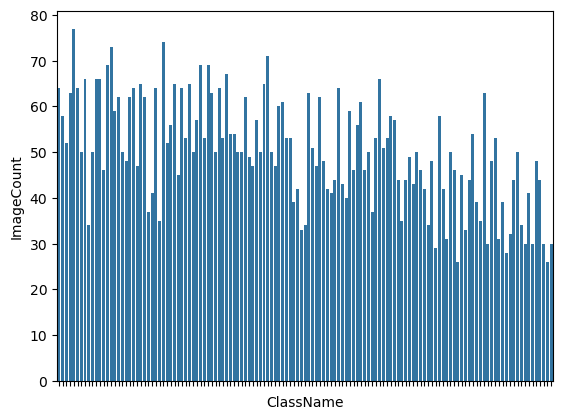

In [8]:
import seaborn as sns
g1 = sns.barplot(x="ClassName", y="ImageCount", data=df)
_ = g1.set(xticklabels=[])

In [108]:
print(f"There are a total of {df['ImageCount'].sum()} training images")

There are a total of 6680 training images


In [82]:
from PIL import Image

im = Image.open('./dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

print(im.size)
print(type(im.size))
# (400, 225)
# <class 'tuple'>

(400, 300)
<class 'tuple'>


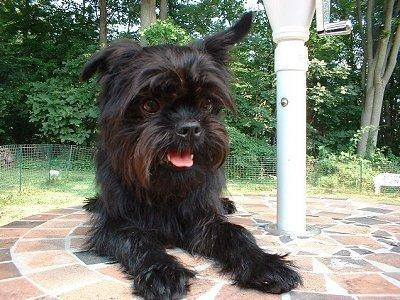

In [83]:
display(im)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [13]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter, 
    HyperparameterTuner
)

In [18]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001,0.01),
    'batch-size': CategoricalParameter([16, 32, 48])
}

In [19]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point='hpo.py', 
    role=role, 
    py_version='py36',
    framework_version='1.6',
    instance_count=1, 
    instance_type='ml.m5.2xlarge'
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Validation average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name, 
    hyperparameter_ranges, 
    metric_definitions, 
    max_jobs=8,
    max_parallel_jobs=4, 
    objective_type=objective_type
)

In [20]:
#https://sagemaker.readthedocs.io/en/stable/overview.html#prepare-a-training-script
os.environ['SM_MODEL_DIR'] = "s3://"+ bucket+ "/model/"

In [22]:
inputs = {
    'train': f's3://{bucket}/dogImages/train', # available as SM_CHANNEL_TRAIN in script
    'validation': f's3://{bucket}/dogImages/valid', # available as SM_CHANNEL_VALIDATION in script
    'test': f's3://{bucket}/dogImages/test' # available as SM_CHANNEL_TEST in script
}

tuner.fit(inputs=inputs, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [23]:
import json

# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() 

# Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print(json.dumps(best_hyperparameters, indent=2))


2024-10-13 16:27:59 Starting - Found matching resource for reuse
2024-10-13 16:27:59 Downloading - Downloading the training image
2024-10-13 16:27:59 Training - Training image download completed. Training in progress.
2024-10-13 16:27:59 Uploading - Uploading generated training model
2024-10-13 16:27:59 Completed - Resource released due to keep alive period expiry
{
  "_tuning_objective_metric": "\"average test loss\"",
  "batch-size": "\"32\"",
  "lr": "0.0016107945947154707",
  "sagemaker_container_log_level": "20",
  "sagemaker_estimator_class_name": "\"PyTorch\"",
  "sagemaker_estimator_module": "\"sagemaker.pytorch.estimator\"",
  "sagemaker_job_name": "\"pytorch-training-2024-10-13-15-44-41-767\"",
  "sagemaker_program": "\"hpo.py\"",
  "sagemaker_region": "\"eu-central-1\"",
  "sagemaker_submit_directory": "\"s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-15-44-41-767/source/sourcedir.tar.gz\""
}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [24]:
#https://sagemaker.readthedocs.io/en/stable/api/training/profiler.html#profiler
from sagemaker import ProfilerConfig
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig, DebuggerHookConfig,FrameworkProfile

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params = FrameworkProfile(num_steps=10))

# https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/pt-resnet-profiling-single-gpu-single-node.ipynb

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # loss_not_decreasing: checks if loss is decreasing and triggers if the loss has not decreased by a certain persentage in the last few iterations. This requires setting of collection_names
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()) # ProfilerReport: runs the entire set of performance rules and create a final output report with further insights and recommendations.
]

# In train_model.py I am using CrossEntropyLoss as loss function, according to https://aws.amazon.com/blogs/machine-learning/detecting-hidden-but-non-trivial-problems-in-transfer-learning-models-using-amazon-sagemaker-debugger/ the tenso name is CrossEntropyLoss_output_0

collection_config = [
    CollectionConfig(
        name = "CrossEntropyLoss_output_0", 
        parameters = {
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "10"
        }
    )
]

debugger_hook_config = DebuggerHookConfig(collection_configs = collection_config)

# This is the list of available collection names https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#built-in-collections

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
# TODO: Create and fit an estimator

hyperparameters = {
    'batch-size': 32,
    'epochs': 2,
    'lr': 0.0016
}

estimator_profiling_debugging = PyTorch(
    entry_point='train_model.py', 
    role=role, 
    py_version='py36',
    framework_version='1.6',
    instance_count=1, 
    instance_type='ml.m5.2xlarge',
    hyperparameters = hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_hook_config, 
    rules = rules 
)

estimator_profiling_debugging.fit(inputs=inputs, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-13-16-48-02-522


In [26]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug import modes


tensors_path = estimator_profiling_debugging.latest_job_debugger_artifacts_path()
print(f"tensors path is: {tensors_path}")
trial = create_trial(tensors_path)

print(f"Tensor names are: {trial.collections}")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=modes.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=modes.EVAL)))

[2024-10-13 17:23:45.973 default:132 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
tensors path is: s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/debug-output
[2024-10-13 17:23:46.020 default:132 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/debug-output
[2024-10-13 17:23:48.654 default:132 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-10-13 17:23:49.671 default:132 INFO trial.py:210] Loaded all steps
Tensor names are: <bound method Trial.collections of <smdebug.trials.s3_trial.S3Trial object at 0x7f51ad1a0520>:(
    name=debug-output,
    path=s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/debug-output/,
    steps=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 209, 219, 229, 237, 247, 257, 267, 277, 287, 297, 307, 317, 327, 337, 347,

In [37]:
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)

{0: array(4.948652, dtype=float32),
 10: array(5.8983836, dtype=float32),
 20: array(4.5926523, dtype=float32),
 30: array(3.9945002, dtype=float32),
 40: array(3.9133515, dtype=float32),
 50: array(2.9802268, dtype=float32),
 60: array(3.2547202, dtype=float32),
 70: array(3.239866, dtype=float32),
 80: array(3.0601132, dtype=float32),
 90: array(2.3151731, dtype=float32),
 100: array(2.941186, dtype=float32),
 110: array(3.1976328, dtype=float32),
 120: array(2.273378, dtype=float32),
 130: array(1.954679, dtype=float32),
 140: array(2.2221072, dtype=float32),
 150: array(2.8160334, dtype=float32),
 160: array(2.5544922, dtype=float32),
 170: array(2.6272538, dtype=float32),
 180: array(1.6872287, dtype=float32),
 190: array(1.5887679, dtype=float32),
 200: array(1.76469, dtype=float32),
 210: array(1.6114116, dtype=float32),
 220: array(1.1579024, dtype=float32),
 230: array(1.6515495, dtype=float32),
 240: array(1.8091477, dtype=float32),
 250: array(1.942655, dtype=float32),
 260:

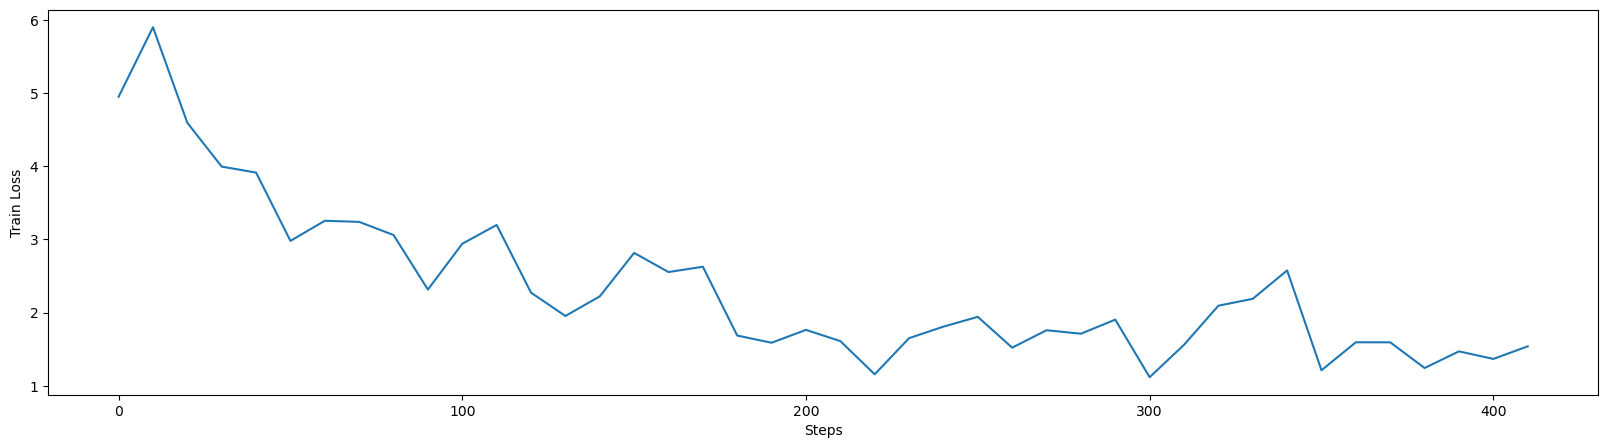

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()
     

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [35]:
estimator_profiling_debugging.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-central-1:493540313520:processing-job/pytorch-training-2024-10-1-LossNotDecreasing-bbb3821d',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 10, 13, 17, 13, 25, 423000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-central-1:493540313520:processing-job/pytorch-training-2024-10-1-VanishingGradient-8c1c11bb',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 10, 13, 17, 13, 25, 423000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-central-1:493540313520:processing-job/pytorch-training-2024-10-1-Overfit-232fef79',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 10, 13, 17, 13, 25, 423000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtrainin

Apprently in my case I have a PoorWeightInitialization, however all weights are fixed but the last layer. So I am not really sure how mucht the issue is relevant when doing fine-tuning instead of training from scratch.

I am wondering why the rule for LossNotDecreasing did not find an issue, since the Train Loss graph indicates training should have stopped much earlier.

In [29]:
# TODO: Display the profiler output
rule_output_path = estimator_profiling_debugging.output_path + estimator_profiling_debugging.latest_training_job.job_name + "/rule-output"
print(rule_output_path)

s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/rule-output


In [31]:
!aws s3 cp {rule_output_path} ./ --recursive --quiet

In [34]:
import IPython
IPython.display.HTML("./ProfilerReport/profiler-output/profiler-report.html")

## Model Deploying

In [40]:
model_data = estimator_profiling_debugging.model_data
print(f"Model: {model_data}")

Model: s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/output/model.tar.gz


In [51]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorch, PyTorchModel

pytorch_model = PyTorchModel(model_data = model_data,
                             role = role,
                             entry_point= "inference.py",
                             py_version = "py36",
                             framework_version = "1.6"
                            )

# TODO: Add your deployment configuration like instance type and number of instances
predictor=pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.xlarge")

# Not creating the endpoint from the estimator but from the model arifacts
#predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Repacking model artifact (s3://sagemaker-eu-central-1-493540313520/pytorch-training-2024-10-13-16-48-02-522/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-eu-central-1-493540313520/pytorch-inference-2024-10-13-18-48-51-701/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-10-13-18-49-02-747
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-10-13-18-49-03-482
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-10-13-18-49-03-482


------!

In [79]:
# TODO: Run an prediction on the endpoint
from PIL import Image
from io import BytesIO
import numpy as np
import torch.nn.functional as F 
import torch

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

predictor.serializer = jpeg_serializer
predictor.deserializer = json_deserializer

def predict_image(path, actual_class):
    with open(path , "rb") as f:
        payload = f.read()        
        # response = predictor.predict(payload)
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        index = np.argmax(response)
        loss = response[0][index]
        soft_outputs = F.softmax(torch.tensor(response), dim=1)
        probability = soft_outputs[0][index]
        
        print(f'Actual class: {actual_class}, Predicted class: {index+1}, Loss: {loss}, Probability: {probability}')
        display(Image.open(BytesIO(payload)))

Actual class: 11, Predicted class: 11, Loss: -1.3076300621032715, Probability: 0.787473738193512


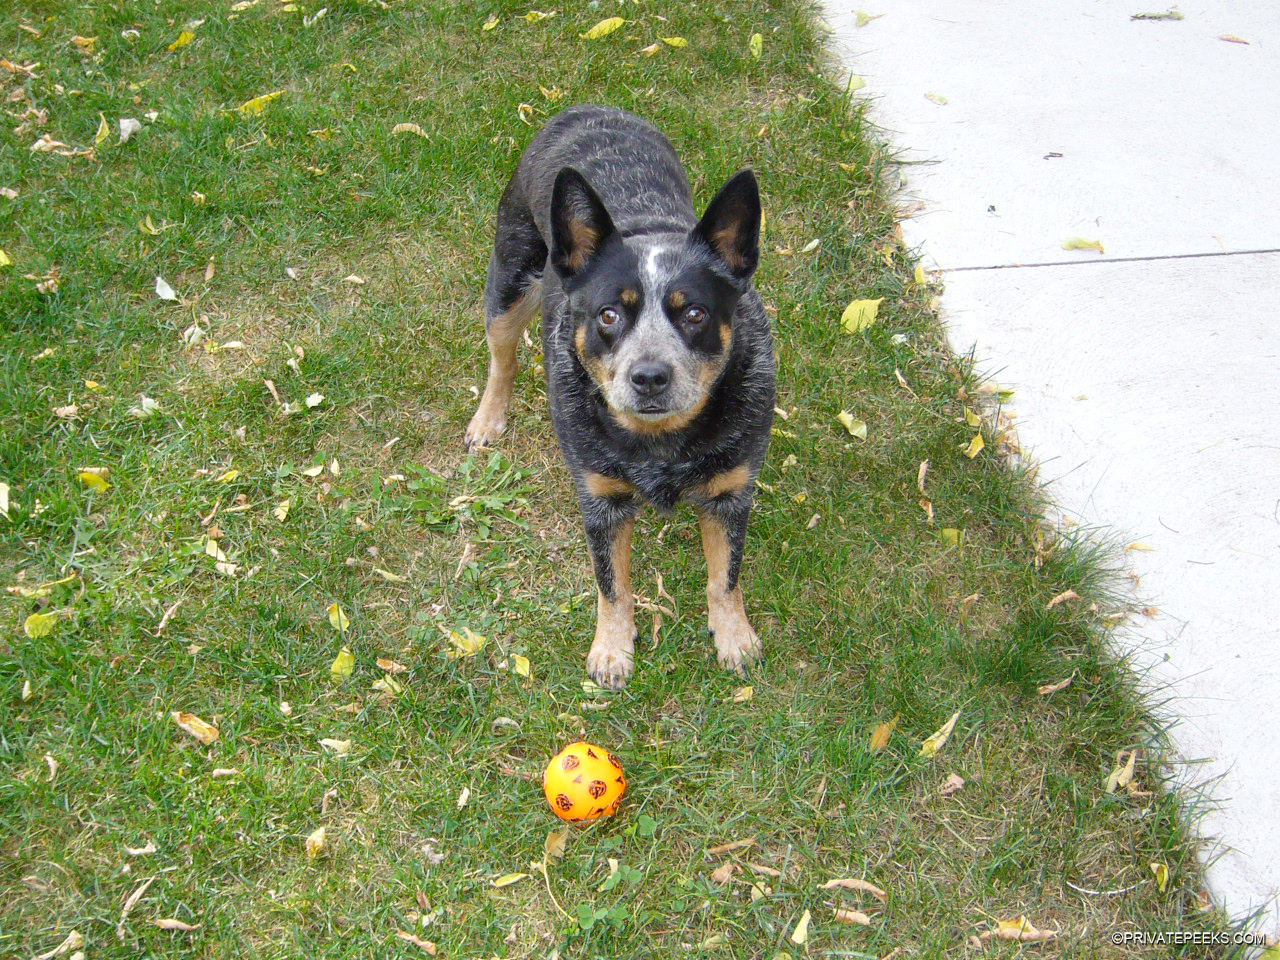

In [80]:
predict_image("./dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00727.jpg", "11")

Actual class: 23, Predicted class: 23, Loss: -1.733451247215271, Probability: 0.6104890704154968


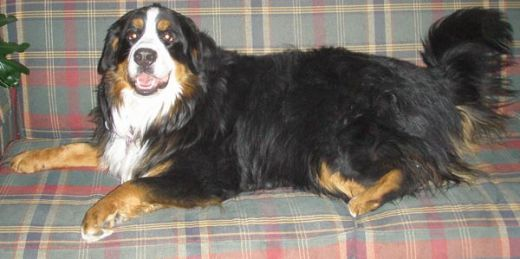

In [81]:
predict_image("./dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01638.jpg", "23")

In [82]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-10-13-18-49-03-482
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-10-13-18-49-03-482
